# Dogs vs Cat Redux

In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [2]:
#Verify we are in the lesson1 directory
%pwd

u'/home/ubuntu/nbs/lesson1'

In [3]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux'

In [13]:
print current_dir
print LESSON_HOME_DIR
print DATA_HOME_DIR

/home/ubuntu/nbs/lesson1
/home/ubuntu/nbs/lesson1
/home/ubuntu/nbs/lesson1/data/redux


In [5]:
#Allow relative imports to directories above lesson1/
#We do this so we can import utils and vgg16
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [6]:
#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Action Plan

So, what do we need to actually do to submit a working model? First, we need to structure our data by creating a Validation and Sample set. Then we need to rearrange the image files into their respective directories. Once we do this, we can finetune and train our model, generate our predictions, validate the predictions, and submit them to Kaggle.<br>
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create validation set and sample

Fun trick - Jupyter Notebooks allow you to write your Terminal commands without leaving the notebook. To invoke *magic* commands, start a line with **"%"**, and to use *BASH* commands, start a line with **"!"**.

In [7]:
#Let's start by moving to our DATA_HOME_DIR (/data/redux/)
%cd $DATA_HOME_DIR

/home/ubuntu/nbs/lesson1/data/redux


In [8]:
%ls $redux

results/  sample/  sample_submission.csv  test/  train/  valid/


In [10]:
# make a validation folder
%mkdir valid

# make a results folder
%mkdir results

# make a sample folder with train, test, validation and results subfolders
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results

# add an unknown folder to test
%mkdir -p test/unknown

In [9]:
%ls $redux

results/  sample/  sample_submission.csv  test/  train/  valid/


In [10]:
# Let's move into our train directory to structure the data
%cd $DATA_HOME_DIR/train

/home/ubuntu/nbs/lesson1/data/redux/train


In [13]:
%ls $train

cat.0.jpg      cat.3250.jpg  cat.7751.jpg   dog.12250.jpg  dog.5500.jpg
cat.10000.jpg  cat.3251.jpg  cat.7752.jpg   dog.12251.jpg  dog.5501.jpg
cat.10001.jpg  cat.3252.jpg  cat.7753.jpg   dog.12252.jpg  dog.5502.jpg
cat.10002.jpg  cat.3253.jpg  cat.7754.jpg   dog.12253.jpg  dog.5503.jpg
cat.10003.jpg  cat.3254.jpg  cat.7755.jpg   dog.12254.jpg  dog.5504.jpg
cat.10004.jpg  cat.3255.jpg  cat.7756.jpg   dog.12255.jpg  dog.5505.jpg
cat.10005.jpg  cat.3256.jpg  cat.7757.jpg   dog.12256.jpg  dog.5506.jpg
cat.10006.jpg  cat.3257.jpg  cat.7758.jpg   dog.12257.jpg  dog.5507.jpg
cat.10007.jpg  cat.3258.jpg  cat.7759.jpg   dog.12258.jpg  dog.5508.jpg
cat.10008.jpg  cat.3259.jpg  cat.775.jpg    dog.12259.jpg  dog.5509.jpg
cat.10009.jpg  cat.325.jpg   cat.7760.jpg   dog.1225.jpg   dog.550.jpg
cat.1000.jpg   cat.3260.jpg  cat.7761.jpg   dog.12260.jpg  dog.5510.jpg
cat.10010.jpg  cat.3261.jpg  cat.7762.jpg   dog.12261.jpg  dog.5511.jpg
cat.10011.jpg  cat.3262.jpg  cat.7763.jpg   dog.12262.jpg  dog.55

Okay! So we have thousands of .jpg files of dogs and cats. We want to shuffle all of the images then move 2000 images into our validation set.

In [14]:
# glob finds all the path names matching a pattern. In this case, if the file ends with ".jpg"
g = glob('*.jpg')

# use numpy.random.permutation to shuffle the images
shuf = np.random.permutation(g)

# move the first 2000 into our validation set
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [11]:
# import the copyfile module which allows you to copy a file into a new folder
from shutil import copyfile

In [16]:
# grab all the images again
g = glob('*.jpg')

# shuffle them again
shuf = np.random.permutation(g)

# add the first 200 to our sample train folder
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [17]:
# move to the validation folder
%cd $DATA_HOME_DIR/valid

/home/ubuntu/nbs/lesson1/data/redux/valid


In [18]:
# shuffle the 2000 images in here and put the first 50 into the sample validation folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories

In [12]:
#Divide cat/dog images into separate directories

# Change to the sample/train directory
%cd $DATA_HOME_DIR/sample/train
# create one folder for cats and one for dogs
%mkdir cats
%mkdir dogs
# put all images beginning with cat into cat folder @ dogs in dog folder
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Repeat for sample/validation
%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Repeat for actual validation
%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# And repeat for actual train
%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/lesson1/data/redux/sample/train
/home/ubuntu/nbs/lesson1/data/redux/sample/valid
/home/ubuntu/nbs/lesson1/data/redux/valid
/home/ubuntu/nbs/lesson1/data/redux/train


In [14]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/nbs/lesson1/data/redux/test


## Finetuning and Training

In [15]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'

# set the path for the test data
test_path = DATA_HOME_DIR + '/test/' #We use all the test data

# set path for results data
results_path=DATA_HOME_DIR + '/results/'

# set path for training data
train_path=path + '/train/'

# set path for validation data
valid_path=path + '/valid/'

/home/ubuntu/nbs/lesson1/data/redux


In [16]:
#import Vgg16 helper class
vgg = Vgg16()

In [19]:
# Set constants. You can experiment with no_of_epochs to improve the model

# batch size is the number of photos the model will look at before updating weights
batch_size=64

# 1 epoch cycles through all data and updates weights
no_of_epochs=5

In [20]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [21]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 766s - loss: 0.3665 - acc: 0.9692 - val_loss: 0.2243 - val_acc: 0.9835
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 767s - loss: 0.3614 - acc: 0.9737 - val_loss: 0.2511 - val_acc: 0.9835
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 768s - loss: 0.3499 - acc: 0.9760 - val_loss: 0.3078 - val_acc: 0.9790
Running epoch: 3
Epoch 1/1
23000/23000 [==============================] - 767s - loss: 0.3303 - acc: 0.9775 - val_loss: 0.2902 - val_acc: 0.9805
Running epoch: 4
Epoch 1/1
23000/23000 [==============================] - 767s - loss: 0.3453 - acc: 0.9767 - val_loss: 0.2053 - val_acc: 0.9870
Completed 5 fit operations


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [22]:
# This will return our predictions as percentages
# Similar to Keras 'predict_generator' which outputs labels
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [23]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.0000e+00   0.0000e+00]
 [  7.9698e-08   1.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


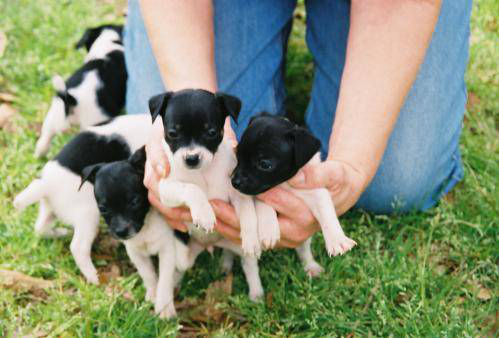

In [30]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[4])

In [31]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [32]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [33]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [34]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [35]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1969 correct labels


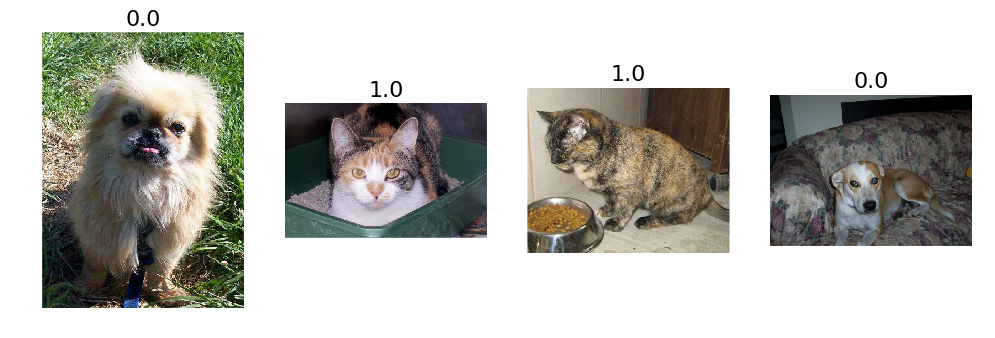

In [36]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 31 incorrect labels


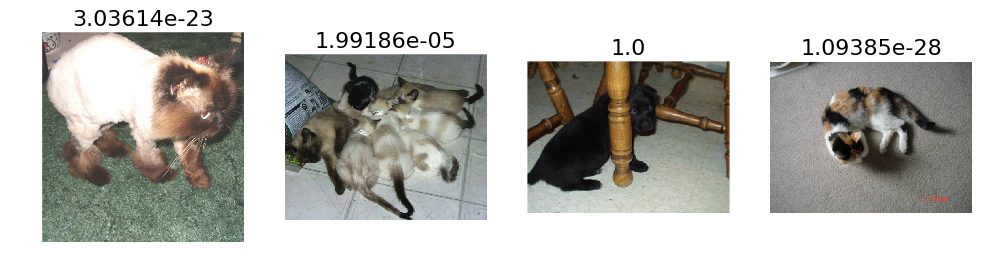

In [39]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 974 confident correct cats labels


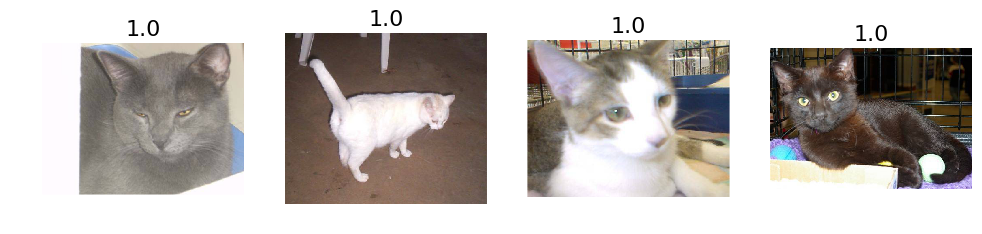

In [41]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 995 confident correct dogs labels


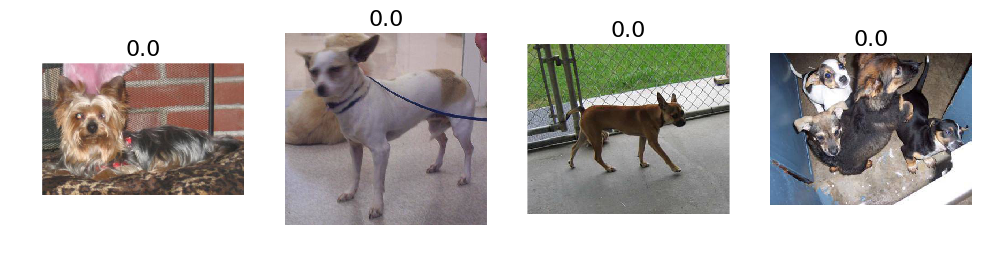

In [42]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 12 incorrect cats


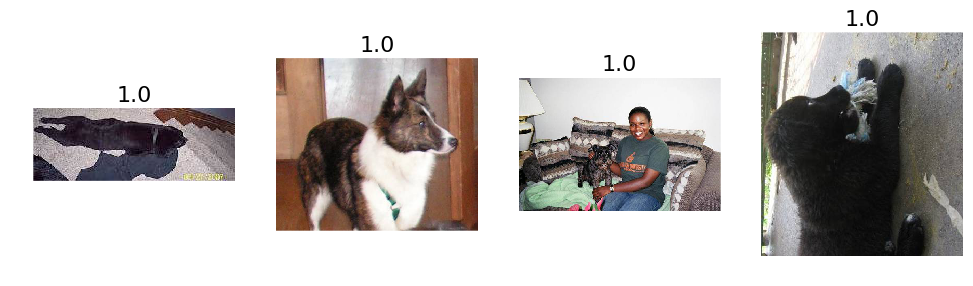

In [43]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 19 incorrect dogs


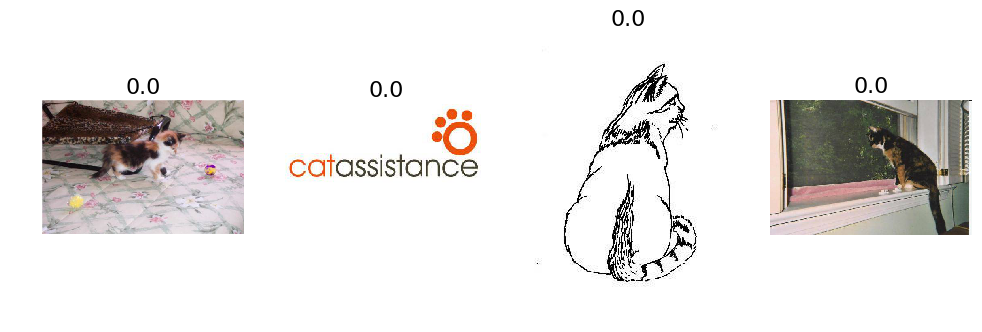

In [45]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

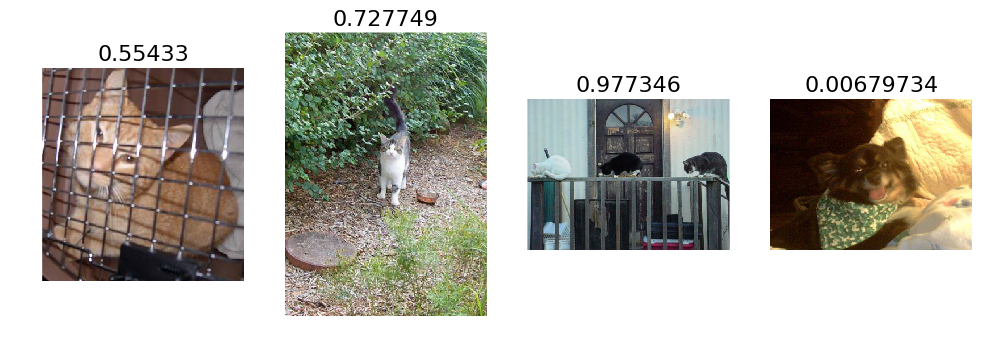

In [46]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[974  19]
 [ 12 995]]


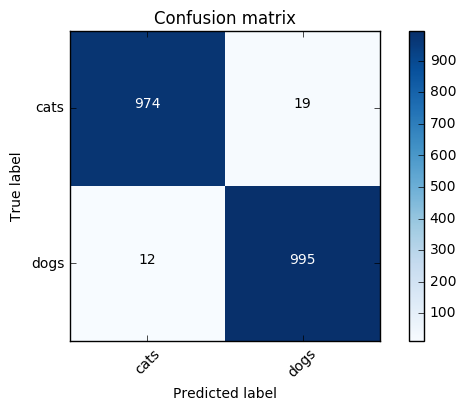

In [48]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [49]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [50]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [ 0.  1.  0.  0.  1.]
Mid Predictions: [ 0.5521  0.5916  0.5755]
Edge Predictions: [ 0.  0.  0. ...,  0.  0.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

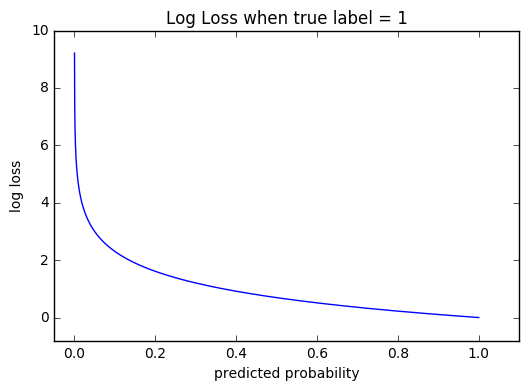

In [51]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [52]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [53]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Here we join the two columns into an array of [imageId, isDog]

In [54]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   9.5000e-01],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [55]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/nbs/lesson1/data/redux


In [56]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)

/home/ubuntu/nbs/lesson1


/home/ubuntu/nbs/lesson1/data/redux/submission1.csv

You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.